<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Fast_ai_lesson_2_pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get data from Kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manimaranp","key":"8921df8fd145f95bd0ed33a6dcc7cab2"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jun  8 06:09 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset

 94% 126M/134M [00:01<00:00, 83.3MB/s]
100% 134M/134M [00:01<00:00, 95.7MB/s]


In [0]:
!unzip /content/complete-pokemon-image-dataset.zip


In [0]:
!rm /content/complete-pokemon-image-dataset.zip

### Load required libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

### Prepare Data for training

In [0]:
path = Path(".")
# path.ls()

In [0]:
data = ImageDataBunch.from_folder(path, train=".",
                                    ds_tfms=get_transforms(),
                                    size=128, valid_pct=0.2).normalize(imagenet_stats)

In [5]:
len(data.classes)

928

### Train Model

In [0]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

In [10]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,6.423382,5.770727,0.898357,01:30
1,3.808653,2.804677,0.537229,01:29
2,2.165013,1.573259,0.355447,01:29
3,1.613778,1.236205,0.280990,01:31
4,1.214877,1.097210,0.247312,01:31
5,0.894916,0.982263,0.225604,01:31
6,0.653492,0.905235,0.205518,01:31
7,0.485139,0.844576,0.192534,01:31
8,0.396958,0.813423,0.182187,01:31
9,0.338902,0.809525,0.181578,01:31


In [0]:
# saves the current state of model
learn.export()

In [0]:
learn.save('stage-1_10_epoch')

### Interpret the model

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

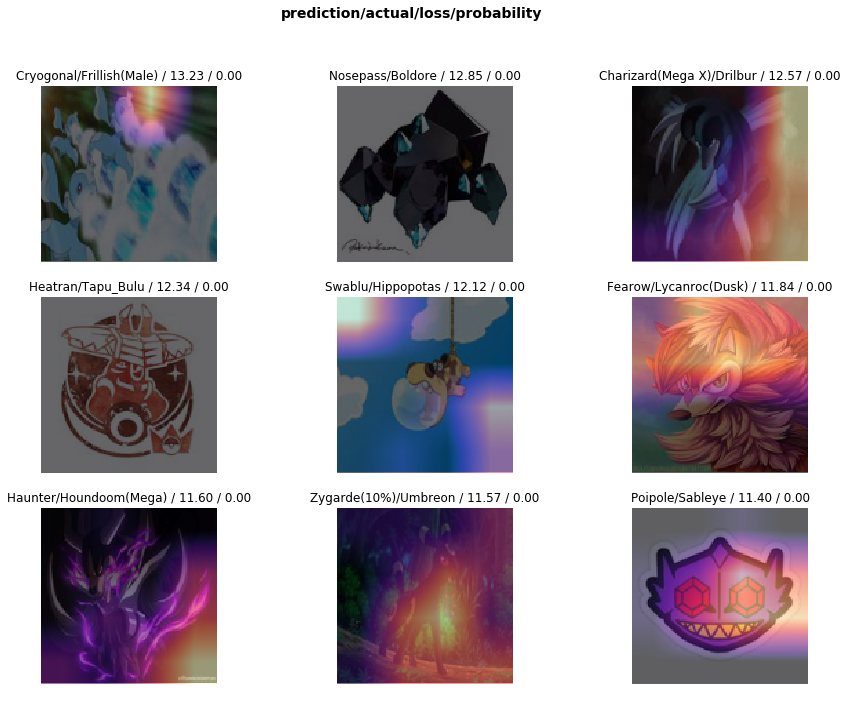

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

In [16]:
interp.most_confused(min_val=3)

[('Latios(Mega)', 'Latias(Mega)', 5),
 ('Groudon(Primal)', 'Groudon', 3),
 ('Stantler', 'Sawsbuck(Summer)', 3),
 ('Zubat', 'Golbat', 3)]

### Fine tune with Learning rate finder

In [0]:
learn.load('stage-1_10_epoch');

In [22]:
learn.lr_find(start_lr=1e-12)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


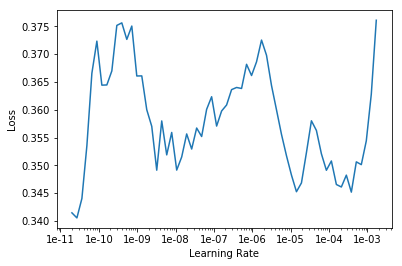

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,0.317702,0.799865,0.179752,02:02
1,0.306358,0.790314,0.177521,02:02
2,0.277683,0.786882,0.173666,02:02


In [59]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.303410,0.784519,0.175492,01:59
1,0.286108,0.774379,0.173260,02:00
2,0.269746,0.773673,0.173666,02:01


In [0]:
from fastai.callbacks import SaveModelCallback

In [64]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5),
                    callbacks=[SaveModelCallback(learn, every='epoch',
                                                 monitor='error_rate')])

epoch,train_loss,valid_loss,error_rate,time
0,0.311204,0.785622,0.176304,02:01
1,0.283675,0.776924,0.173057,02:01
2,0.279131,0.770470,0.174072,02:00
3,0.264715,0.759300,0.171434,02:01
4,0.258948,0.752003,0.169000,02:00
5,0.238618,0.750021,0.168797,02:00
6,0.229438,0.746300,0.167377,02:00
7,0.222334,0.742271,0.167580,02:00
8,0.217958,0.738850,0.166565,02:01
9,0.219041,0.741899,0.168594,02:00


In [66]:
!ls models

models
models/bestmodel_7.pth
models/tmp.pth
models/stage-1_3_epoch.pth
models/bestmodel_8.pth
models/bestmodel_2.pth
models/bestmodel_9.pth
models/bestmodel_3.pth
models/bestmodel_6.pth
models/bestmodel_1.pth
models/bestmodel_0.pth
models/stage-1_10_epoch.pth
models/bestmodel_5.pth
models/stage-1_7_epoch.pth
models/bestmodel_4.pth
models/stage-2_3_epoch.pth


### Save best model to gdrive

In [0]:
learn.load('bestmodel_8');

In [0]:
learn.export(file="pokemon_v1.pkl")

In [76]:
!find pokemon_v1.pkl

find: ‘/My Drive’: No such file or directory


In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [78]:
!cp -v pokemon_v1.pkl '/content/gdrive/My Drive/pokemon_v1.pkl'

'pokemon_v1.pkl' -> '/content/gdrive/My Drive/pokemon_v1.pkl'


### Experiments with Learning rate finder

In [55]:
learn.lr_find(start_lr=1e-100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


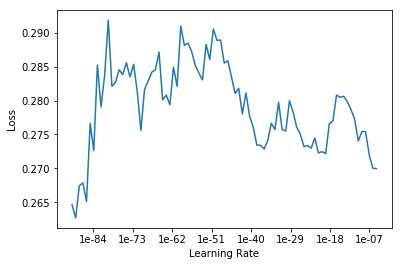

In [56]:
learn.recorder.plot()

In [0]:
learn.load('stage-2_3_epoch');

In [57]:
learn.fit_one_cycle(3, max_lr=slice(1e-51,1e-40))

epoch,train_loss,valid_loss,error_rate,time
0,0.283209,0.787188,0.176101,01:57
1,0.282709,0.783940,0.176709,02:00
2,0.297682,0.786172,0.175492,02:01
